In [2]:
import urllib
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib import animation
import pandas_datareader.data as web

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib notebook

In [5]:
start = '2019-03-01'
end = '2019-03-22'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']





def _get_data():
    file = urllib.request.urlopen('https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=month(NEW_DATE)%20eq%203%20and%20year(NEW_DATE)%20eq%202019')
    data = file.read()
    file.close()
    f = xmltodict.parse(data)
    dd = {}
    for i in range(len(f['feed']['entry'])):
        slice_ = f['feed']['entry'][i]['content']['m:properties']
        keys = list(slice_.keys())
        date = slice_['d:NEW_DATE']['#text']
        values_ = []
        for key in keys[2:]:
            values_.append(slice_[key]['#text'])

        dd[date] = values_

    df = pd.DataFrame.from_dict(dd,orient='index')
    df.columns = [key.split('d:')[1] for key in keys[2:]]
    return df #render_to_response('my_template.html', {'data': data})

In [6]:
df = _get_data()
snp500 = get_px('SPY')

In [7]:
sldf = df[['BC_3MONTH','BC_5YEAR','BC_10YEAR']].astype(float)
sldf.index = [x.split('T')[0] for x in sldf.index]
sldf

,BC_3MONTH,BC_5YEAR,BC_10YEAR
2019-03-01,2.44,2.56,2.76
2019-03-04,2.46,2.53,2.72
2019-03-05,2.46,2.53,2.72
2019-03-06,2.47,2.49,2.69
2019-03-07,2.45,2.44,2.64
2019-03-08,2.46,2.42,2.62
2019-03-11,2.46,2.44,2.64
2019-03-12,2.46,2.41,2.61
2019-03-13,2.45,2.42,2.61
2019-03-14,2.45,2.43,2.63


In [8]:
#polinomial fitting
x = np.array([-2.0,0.0,2.0])
xp = np.linspace(-3, 3, 100)
poly_param = pd.DataFrame()

polydf = pd.DataFrame(index=xp)
for i in range(len(sldf)):
    y = np.array(sldf.iloc[i])

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    polydf[sldf.index[i]] = p(xp)
    poly_param = poly_param.append(pd.Series(z,index=['pow3','pow2','pow1','c']),ignore_index=True)
    #_ = plt.plot(x, y, '.', xp, p(xp), '-')
    #time.sleep(2)
    #plt.ylim(-3,3)
poly_param['coef'] = round(poly_param['pow3']*1e3,2)
polydf.head()

,2019-03-01,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22
-3.000000,2.260000,2.348125,2.348125,2.424375,2.444687,2.495000,2.468125,2.508437,2.472500,2.458125,2.499375,2.450000,2.495938,2.649375,2.672812,2.736875
-2.939394,2.274860,2.357724,2.357724,2.428967,2.446199,2.493431,2.468609,2.505842,2.471831,2.458609,2.496652,2.450231,2.494241,2.637538,2.659948,2.716823
-2.878788,2.289145,2.366907,2.366907,2.433278,2.447518,2.491758,2.468932,2.503172,2.471040,2.458932,2.493866,2.450321,2.492453,2.625891,2.647304,2.697198
-2.818182,2.302870,2.375684,2.375684,2.437319,2.448654,2.489989,2.469099,2.500434,2.470133,2.459099,2.491023,2.450278,2.490578,2.614438,2.634883,2.677997
-2.757576,2.316047,2.384067,2.384067,2.441098,2.449614,2.488129,2.469119,2.497634,2.469119,2.459119,2.488129,2.450108,2.488624,2.603180,2.622686,2.659221


<IPython.core.display.Javascript object>


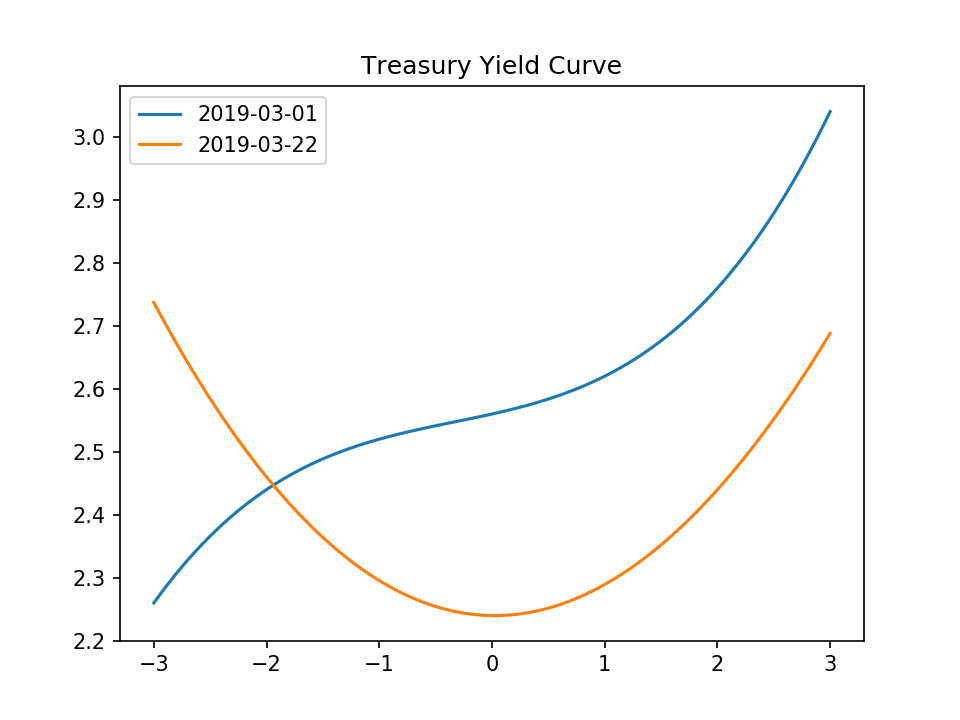

In [9]:
polydf[['2019-03-01','2019-03-22']].plot(title='Treasury Yield Curve')

In [11]:
data = polydf.T.reset_index(drop=True)

poly_coef = poly_param.drop(columns=['c','pow1','pow2','pow3'])
snp500.name = 'snp500'
poly_coef.index = pd.to_datetime(polydf.columns)
poly_coef = poly_coef.join(snp500)

<IPython.core.display.Javascript object>


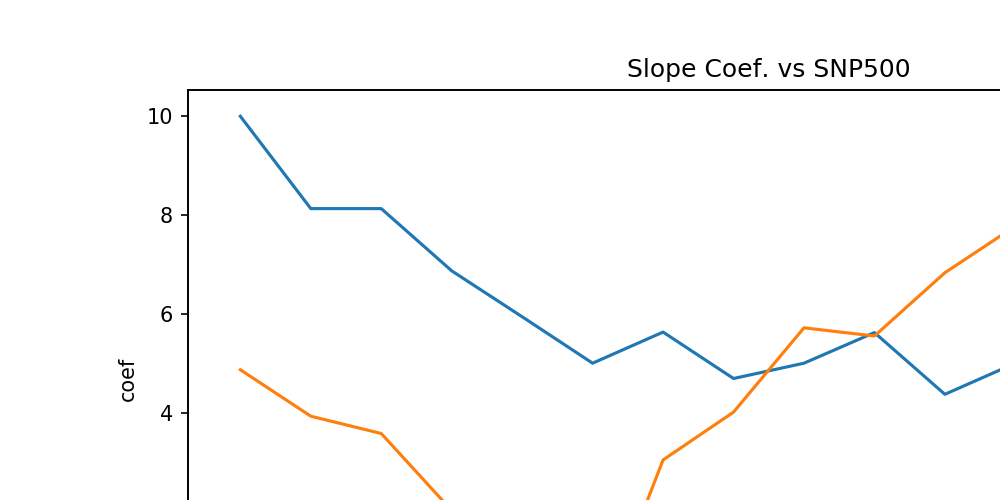

In [10]:
def animate(nframe):
      plt.cla()
      
      plt.plot(x, sldf.iloc[nframe], '.', data.columns.values, data.ix[nframe], '-')
      plt.ylim(2.2,3)
      plt.xlim(-3,4)
      plt.text(2.4, 2.25, 'x=-2 - 3mo\nx=0 - 5y\nx=2 - 10y')
      plt.xlabel('Maturity')
      plt.ylabel('Yield')
      plt.title('Date:'+sldf.iloc[nframe].name+'\nShape coef.: '+str(poly_param.iloc[nframe,4])
               )
      font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
      
    
fig = plt.figure(figsize=(5,4))  

anim = animation.FuncAnimation(fig, animate, frames=16)

In [15]:
anim.save('./yieldcurve.gif', writer='imagemagick', fps=1);

<IPython.core.display.Javascript object>


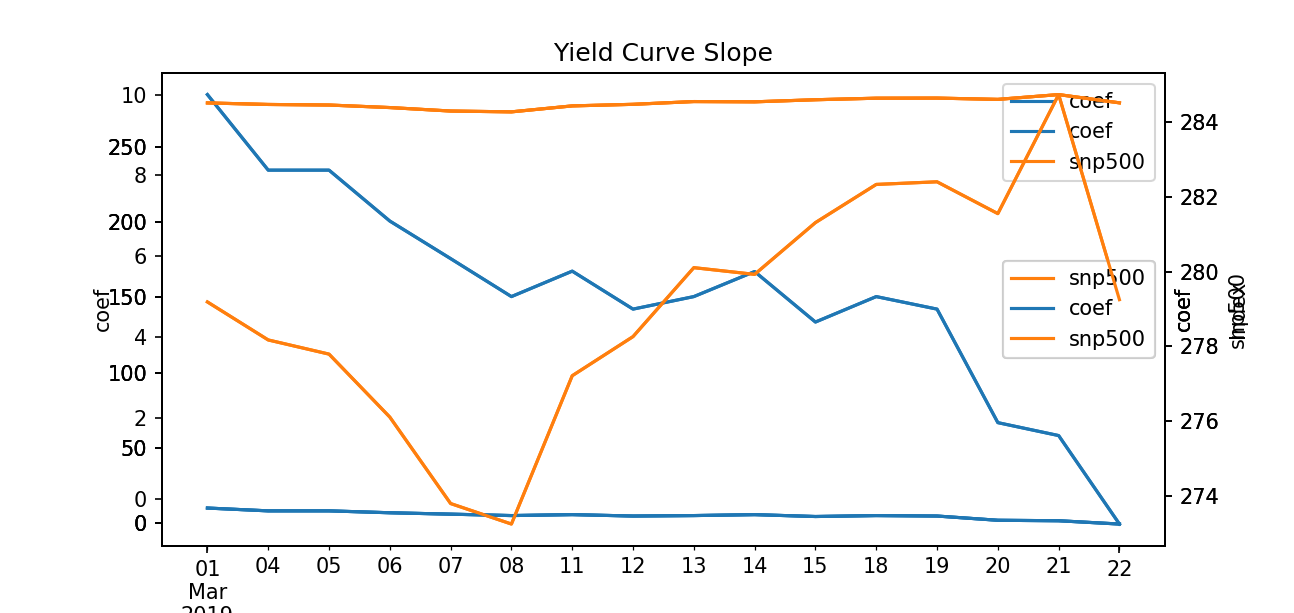

Text(0,0.5,'Index')

In [24]:


#snp500
fig, ax = plt.subplots()
ax = poly_coef['coef'].plot(title='Yield Curve Slope',ax=ax)
ax = poly_coef['snp500'].plot(title='Yield Curve Slope',ax=ax,secondary_y=True)
ax.set_xlabel("Days")
ax.set_ylabel('Index')

In [18]:
def plot_multi(data, cols=None,title='', spacing=.1, **kwargs):

    from pandas import plotting
    plt.figure()
    plt.title(title)
    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_xlabel("Days")
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

<IPython.core.display.Javascript object>


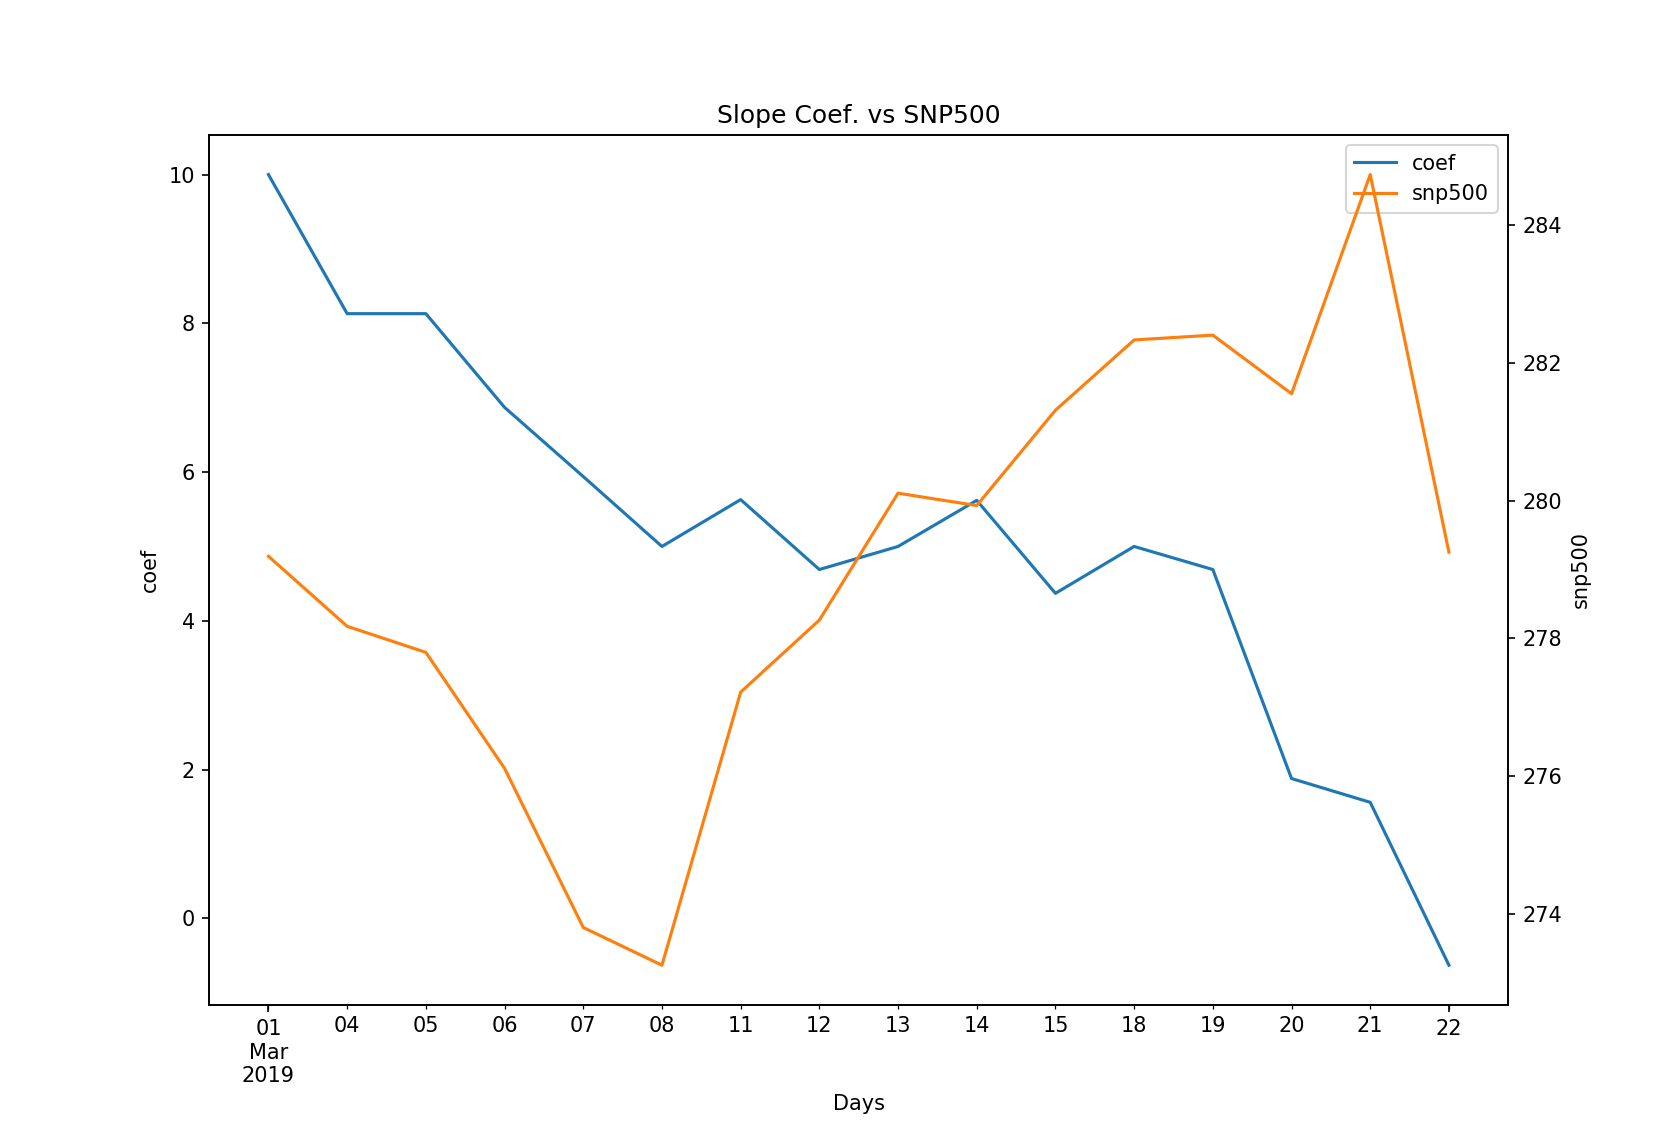

In [19]:
plot_multi(poly_coef,title='Slope Coef. vs SNP500', figsize=(10, 5))